In [1]:
#import all the necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import KNeighborsClassifier

In [2]:
plt.style.use('ggplot')
plt.rc('font', size=20)
plt.rcParams["figure.autolayout"] = True

In [3]:
spirits = [['El Buho Espadin', 3, 0.5, 'Mezcal'],
            ['Casamigos Reposado', 1, 1, 'Mezcal'],
            ['Espolon Anejo',1.5, 2, 'Mezcal'], 
            ['Laphroaig 12', 7, 4, 'Whiskey'],
            ['Macallan 12', 5, 4, 'Whiskey'],
            ['Knob Creek Bourbon', 4, 5, 'Whiskey']]

spirits_df = pd.DataFrame(spirits, columns=['spirit','smokiness', 'color', 'type' ])

spirits_df.head(10)

,spirit,smokiness,color,type
0,El Buho Espadin,3.0,0.5,Mezcal
1,Casamigos Reposado,1.0,1.0,Mezcal
2,Espolon Anejo,1.5,2.0,Mezcal
3,Laphroaig 12,7.0,4.0,Whiskey
4,Macallan 12,5.0,4.0,Whiskey
5,Knob Creek Bourbon,4.0,5.0,Whiskey


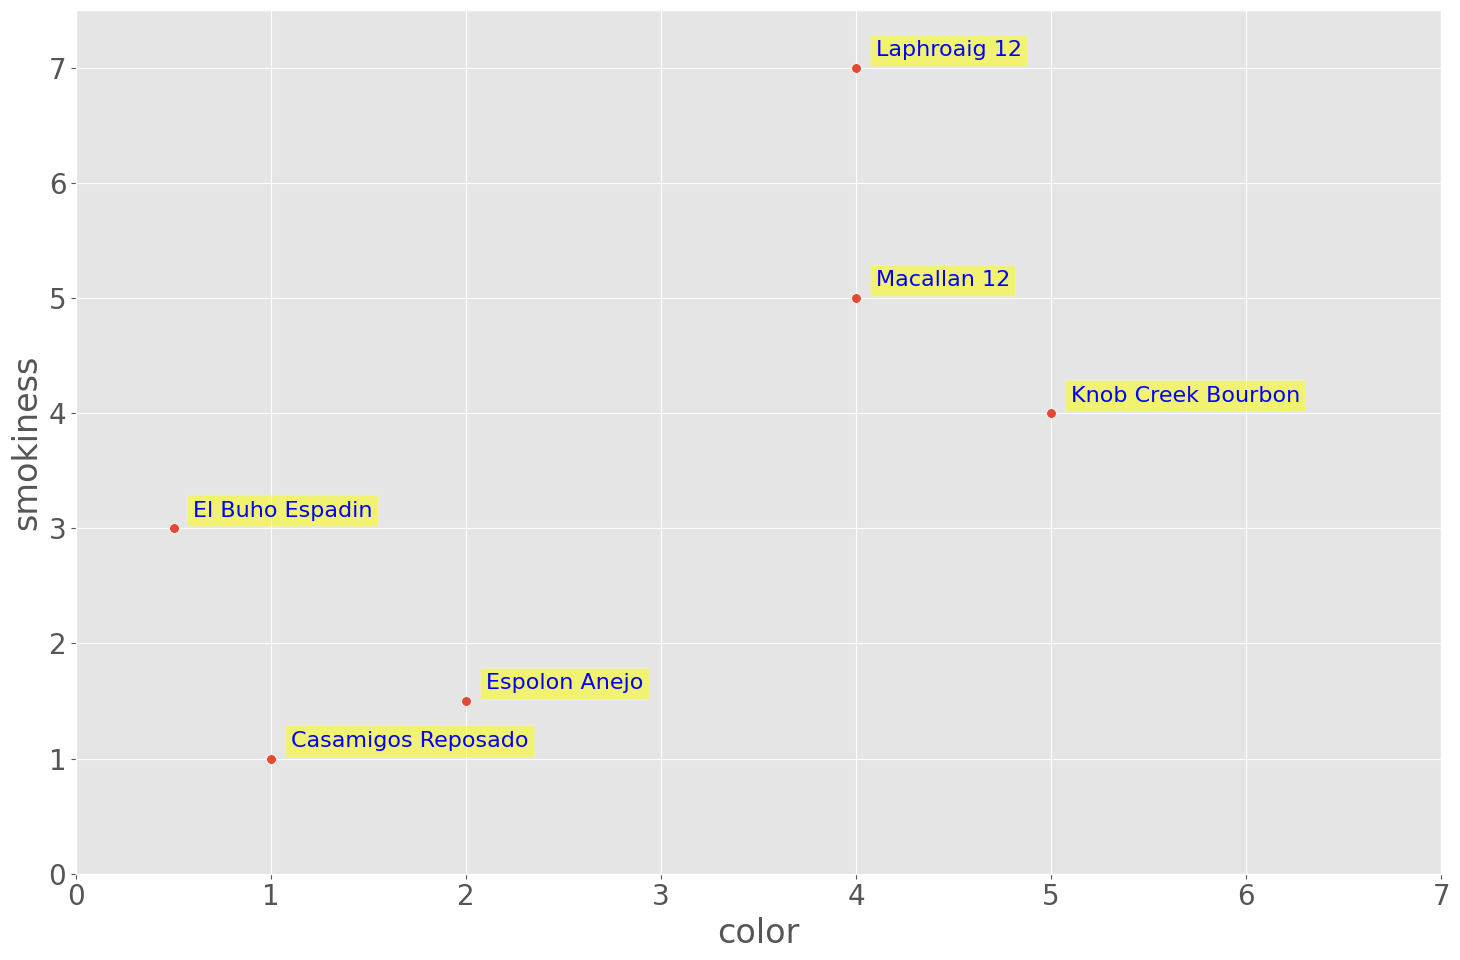

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
sns.scatterplot(y=spirits_df['smokiness'], x=spirits_df['color'], s=50)
plt.xlim([0, 7])
plt.ylim([0,7.5])

for i in range(spirits_df.shape[0]):
    plt.text(x=spirits_df['color'][i]+.1,
             y=spirits_df['smokiness'][i]+.1, 
             s=spirits_df['spirit'][i], 
             fontdict=dict(color='blue',size=16),
             bbox=dict(facecolor='yellow',alpha=0.5))

plt.show()

Euclidean distance is calculated using the following formula:

$D(point1, point2) = \sqrt{\displaystyle\sum_{i=1}^ {N} (point1_{i}-point2_{i})^2}$

 <br />
For our spirits example, we can apply this to the distance between any two spirits using their color and smokiness. We'll start with El Buho (EB) and Laphroaig (L):

$D(L, EB) = \sqrt{(L_{color}-EB_{color})^2 + (L_{smokiness}-EB_{smokiness})^2}$

<br />
Inputting the actual numbers here, we get:

$D(L, EB) = \sqrt{(4-0.5)^2 + (7-3)^2}$

$D(L, EB) = \sqrt{28.25}$

$D(L, EB) = 5.32$

<br />
Now, let's see how we can do that in code. In most coding languages, there is more than one way to skin a cat (this is a terrible expression). But, we'll start with the way that is probably going to seem most familiar.

In [7]:
spirits_df.head()

,spirit,smokiness,color,type
0,El Buho Espadin,3.0,0.5,Mezcal
1,Casamigos Reposado,1.0,1.0,Mezcal
2,Espolon Anejo,1.5,2.0,Mezcal
3,Laphroaig 12,7.0,4.0,Whiskey
4,Macallan 12,5.0,4.0,Whiskey


In [12]:
smokiness_diff = spirits_df['smokiness'][3]-spirits_df['smokiness'][0]
color_diff = spirits_df['color'][3]-spirits_df['color'][0]

D_LEB = (smokiness_diff**2 + color_diff**2)**.5
 

print(f"Distance between Laphroaig and El Buho is {D_LEB}")

distance between Laprhoaig and El Buho is 5.315072906367325


I broke this up into separate steps to make it easier to follow, but we can actually chain them all together within one line of code

In [16]:
D_LEB = ((spirits_df['smokiness'][3]-spirits_df['smokiness'][0])**2 + (spirits_df['color'][3]-spirits_df['color'][0])**2)**0.5
print(f"Distance between Laphroaig and El Buho is {D_LEB}")

distance between Laphroaig and El Buho is 5.315072906367325


As I mentioned above, there are a lot of libraries that can remove some of the work in writing out formulas. Another benefit of using libraries is that they usually reduce the likelihood that you make a mistake in your own implemetation. Let's take a look at the distance funtion for the math module:

In [13]:
help(math.dist)

Help on built-in function dist in module math:

dist(p, q, /)
    Return the Euclidean distance between two points p and q.
    
    The points should be specified as sequences (or iterables) of
    coordinates.  Both inputs must have the same dimension.
    
    Roughly equivalent to:
        sqrt(sum((px - qx) ** 2.0 for px, qx in zip(p, q)))



We can use this function to perform the same distance calculation as we performed above.

In [ ]:
print(f"Distance between El Buho and Laphroaig is: {math.dist([spirits_df['smokiness'][0],spirits_df['color'][0]], [spirits_df['smokiness'][3],spirits_df['color'][3]])}")

The distance between El Buho and Laphroaig is: 5.315072906367325


Using libraries is kind of like the oven maker baker analogy I brought up earlier. If an oven already exists to do whatever you want to do, there really is no reason to try to build one yourself.

<br>

With that out of the way, let's get to the business of making a guess about what kind of spirit our Unknown Spirit is. First, we'll add the Unknown Spirit info to the rest of the data:


In [8]:
unknown_spirit = {'spirit':'Unknown Spirit', 'smokiness':2, 'color':3}
unknown_spirit = pd.DataFrame([unknown_spirit])
                  
spirits_df_us = pd.concat([spirits_df, unknown_spirit], ignore_index=True)

spirits_df_us.head(7)

,spirit,smokiness,color,type
0,El Buho Espadin,3.0,0.5,Mezcal
1,Casamigos Reposado,1.0,1.0,Mezcal
2,Espolon Anejo,1.5,2.0,Mezcal
3,Laphroaig 12,7.0,4.0,Whiskey
4,Macallan 12,5.0,4.0,Whiskey
5,Knob Creek Bourbon,4.0,5.0,Whiskey
6,Unknown Spirit,2.0,3.0,NaN


Now, we're going to use another kind of oven that works well with data in this particular format to calculate the distance between the Unknown Spirit and the rest of the spirits.

In [31]:
df_t = spirits_df_us
df_t['type'] = df_t['type'].fillna('Not Known')

df_t.head(10)

,spirit,smokiness,color,type
0,El Buho Espadin,3.0,0.5,Mezcal
1,Casamigos Reposado,1.0,1.0,Mezcal
2,Espolon Anejo,1.5,2.0,Mezcal
3,Laphroaig 12,7.0,4.0,Whiskey
4,Macallan 12,5.0,4.0,Whiskey
5,Knob Creek Bourbon,4.0,5.0,Whiskey
6,Unknown Spirit,2.0,3.0,Not Known


In [9]:
distances = pdist(spirits_df_us[['smokiness', 'color']].values, metric='euclidean')
dist_matrix = squareform(distances)

#This bit is just rearranging the calculation so it looks like the output in the PDF
us_dist = pd.DataFrame(dist_matrix.round(2),
    columns = spirits_df_us.spirit.values,
    index = spirits_df_us.spirit.values
    )[['Unknown Spirit']]

us_dist.sort_values('Unknown Spirit').head(10)

,Unknown Spirit
Unknown Spirit,0.00
Espolon Anejo,1.12
Casamigos Reposado,2.24
El Buho Espadin,2.69
Knob Creek Bourbon,2.83
Macallan 12,3.16
Laphroaig 12,5.10


Here's a bit of code that will allow us to visualize what the distances look like qualitatively. From the figure below, it's pretty obvious that the Unknown Spirit is closer to the Mezcals than the Whiskeys. 

In [24]:
def plot_all_spirits(df):

  df['type'] = df['type'].fillna('Not Known') #Fill in the type so it gets a market in the plot
  fig, ax = plt.subplots()
  fig.set_size_inches(10, 10)
  sns.scatterplot(y=df['smokiness'], x=df['color'], s=170, style=df['type'])
  plt.xlim([0, 7])
  plt.ylim([0,7.5])
    
  for i in range(df.shape[0]):
    plt.text(x=df['color'][i]+.1, #little jitter to make it so that the labels don't overlap the dots
             y=df['smokiness'][i]+.1, 
             s=df['spirit'][i], 
             fontdict=dict(color='blue',size=16),
             bbox=dict(facecolor='yellow',alpha=0.5))
    
    #annoying hack to fix legend marker size
    lgnd = plt.legend(loc="lower left", numpoints=1, fontsize=16)
    #plt.legend(loc=1, prop={'size': 25})

    for handle in lgnd.legendHandles:
        handle.set_sizes([200])
        handle.set_color('r')

<ipython-input-24-e52f7eeade7c>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


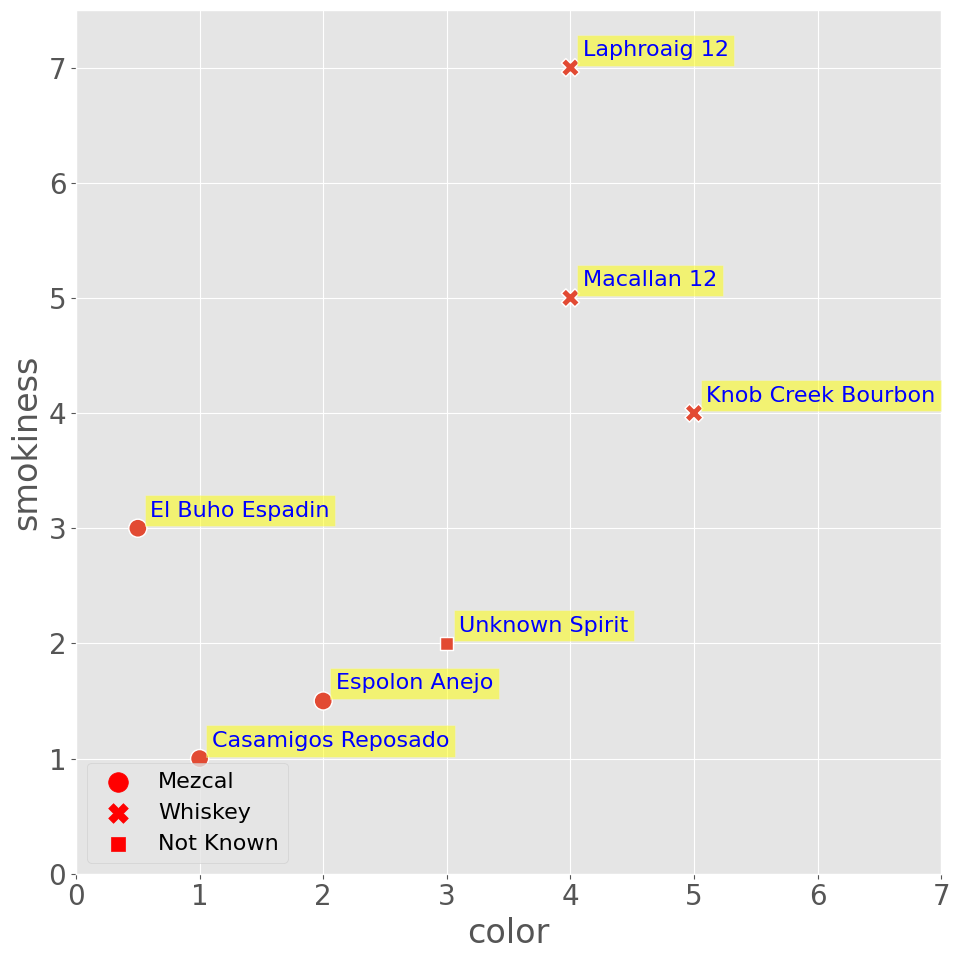

In [25]:
plot_all_spirits(spirits_df_us)

But what would it look like if we changed the ratings of the Unknown Spirit a bit? It's still overall closer to the Mezcal cluster, but the result is not as visually obvious.

<ipython-input-24-e52f7eeade7c>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


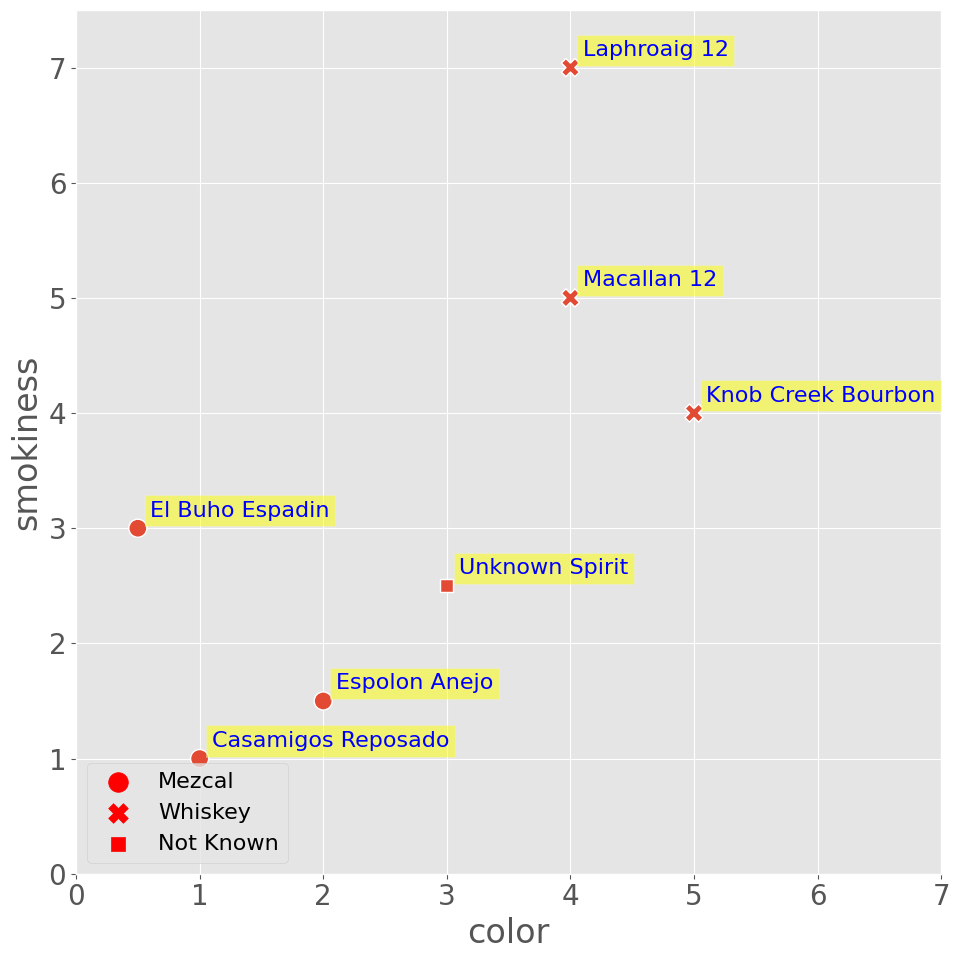

In [26]:
unknown_spirit2 = {'spirit':'Unknown Spirit', 'smokiness':2.5, 'color':3}
unknown_spirit2 = pd.DataFrame([unknown_spirit2])
                  
spirits_df_us2 = pd.concat([spirits_df, unknown_spirit2], ignore_index=True)
distances2 = pdist(spirits_df_us2[['smokiness', 'color']].values, metric='euclidean')
dist_matrix2 = squareform(distances2)

us_dist2 = pd.DataFrame(dist_matrix2.round(2),
    columns = spirits_df_us2.spirit.values,
    index = spirits_df_us2.spirit.values
    )[['Unknown Spirit']]

#us_dist2.sort_values('Unknown Spirit').head(7)
plot_all_spirits(spirits_df_us2)

So, we have already discussed that this type of model is called K-nearest neighbors. You could write your own code to determine the class of the unclassified examples, but fortunately, Python has lots of libraries to do this. Here, we'll be using a library called `scikit-learn` which contains a bunch of machine learning tools. 

In [30]:
uk_smokiness = 2
uk_color = 3

df = spirits_df_us

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(df[['smokiness', 'color']].values, df['type'])
uk_type = neigh.predict([[uk_smokiness,uk_color]])[0]
print(f'Unknown spirit type is: {uk_type}')

Unknown spirit type is: Mezcal


In [31]:
def plot_supervised(df, uk_smokiness, uk_color):
    
    #plot params
    plt.style.use('ggplot')
    plt.rc('font', size=20)
    plt.rcParams["figure.autolayout"] = True
    
    #make a prediction for the uknown spirit type using knn
    neigh = KNeighborsClassifier(n_neighbors=3)
    neigh.fit(df[['smokiness', 'color']].values, df['type'])
    uk_type = neigh.predict([[uk_smokiness,uk_color]])[0]
    print(f'Unknown spirit type is: {uk_type}')
    
    unknown_spirit = {'spirit':'Unknown Spirit','smokiness':uk_smokiness, 'color':uk_color, 'type':uk_type}
    unknown_spirit_df = pd.DataFrame([unknown_spirit])               
    df = pd.concat([df, unknown_spirit_df], ignore_index=True)

    plot_all_spirits(df)

    plt.show()

Unknown spirit type is: Whiskey


<ipython-input-24-e52f7eeade7c>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


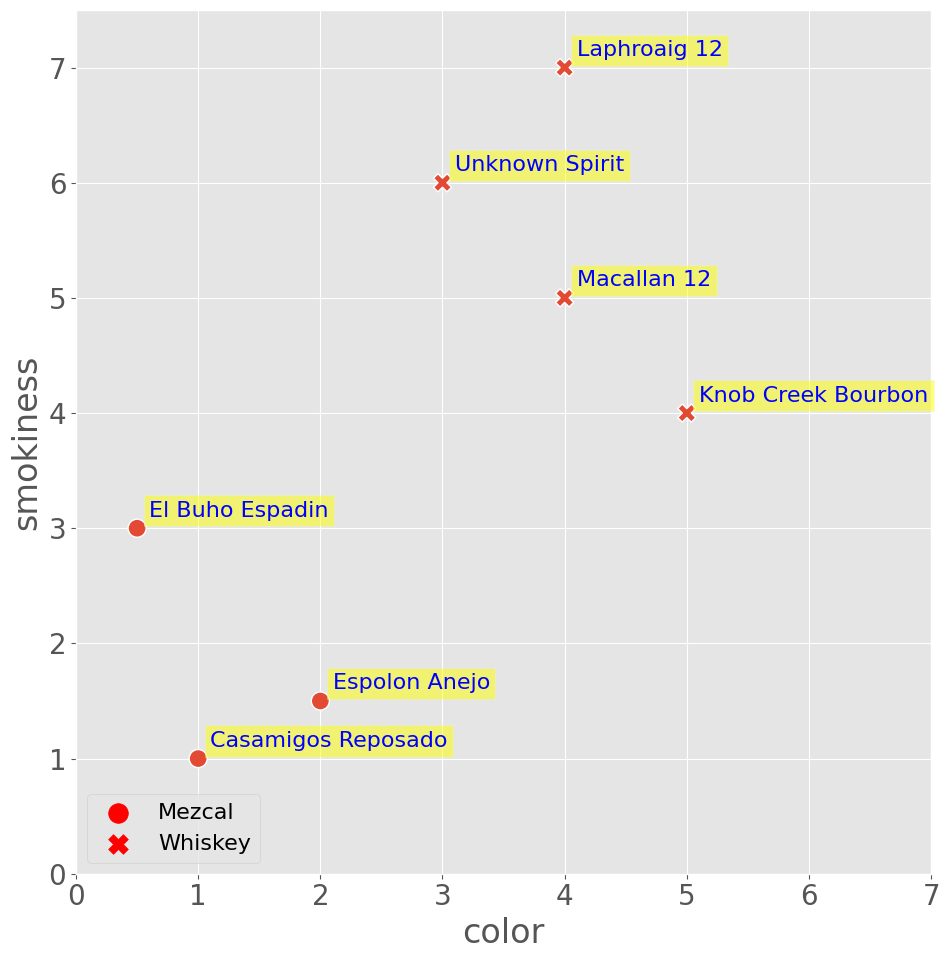

In [33]:
plot_supervised(spirits_df, uk_smokiness=6, uk_color=3)

So far what we have done is use distance to predict the category of a spirit based on the known category of other spirits. That is, we have used distance for supervised learning. In other cases, we may not have a label for groups of entitites, but rather just want to know which entities are grouped together. Then, we can use distance to perform unsupervised learning. We can visualize what this looks like using the figure below.

In [ ]:
def plot_unsupervised(df, uk_smokiness, uk_color):
    
    #plot params
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 15)
    
    plt.xlim([0, 7])
    plt.ylim([0,7.5])

    
    unknown_spirit = {'spirit':'Unknown Spirit','smokiness':uk_smokiness, 'color':uk_color, 'type':'None'}
    unknown_spirit_df = pd.DataFrame([unknown_spirit])               
    df = pd.concat([df, unknown_spirit_df], ignore_index=True)
    
    
    means=df.groupby('type').mean()
    center_m = [means['color']['Mezcal'], means['smokiness']['Mezcal']]
    center_w = [means['color']['Whiskey'], means['smokiness']['Whiskey']]
    
    sns.scatterplot(y=df['smokiness'], x=df['color'], s=170)

    for i in range(df.shape[0]):
        plt.text(x=df['color'][i]+.1,
                 y=df['smokiness'][i]+.1, 
                 s=df['spirit'][i], 
                 fontdict=dict(color='blue',size=16),
                 bbox=dict(facecolor='yellow',alpha=0.5))

    
    ax.add_patch(plt.Circle(center_m, radius=2, color='r', alpha=0.2))
    ax.add_patch(plt.Circle(center_w, radius=2, color='b', alpha=0.2))
    
    if save_fig:
        plt.savefig('./figures/unsupervised-learning.png')
    else:
        plt.show()

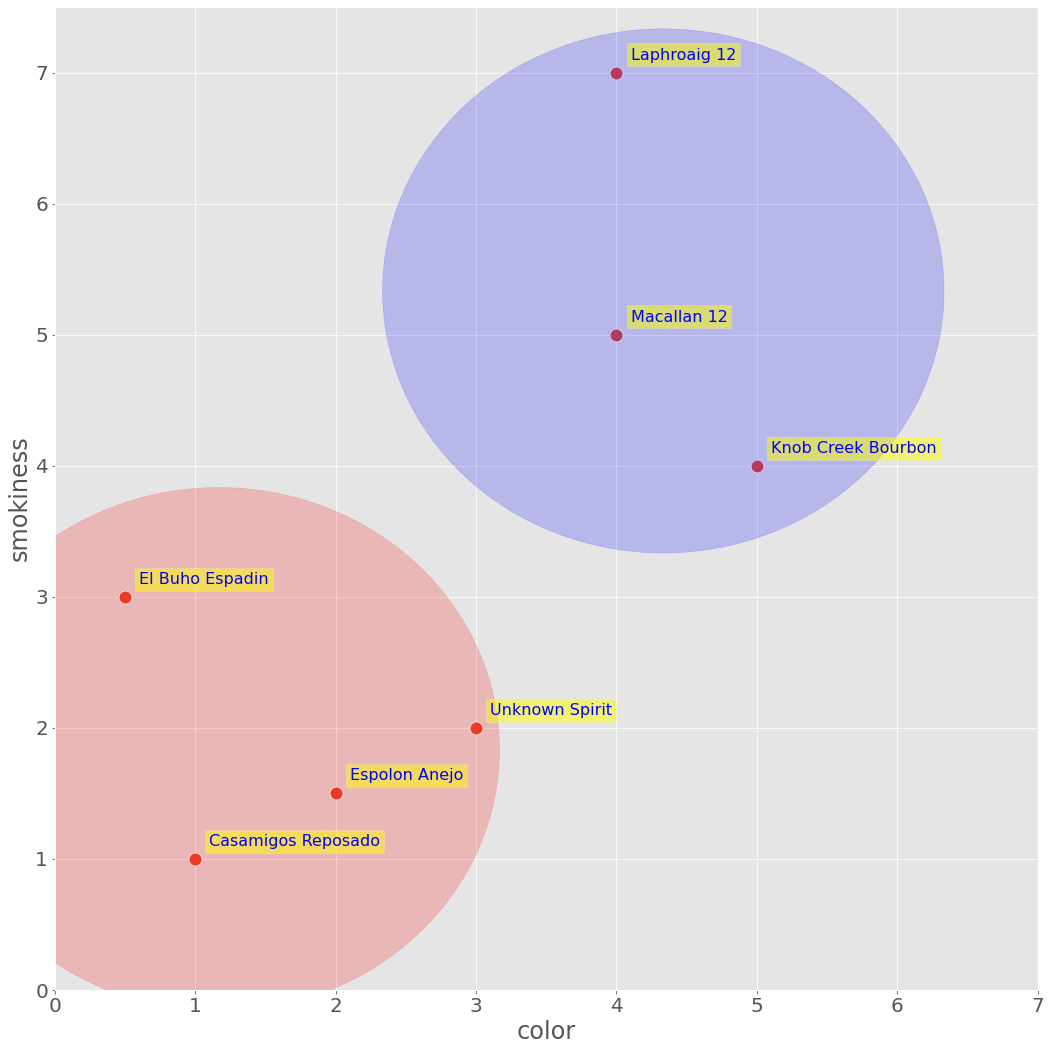

In [ ]:
plot_unsupervised(spirits_df, 2,3, True)

1.224744871391589